# RGI-07: Region 02 (Western Canada and USA)

F. Maussion, 2021

In [39]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
from utils import mkdir
import numpy as np

## Files and storage paths

In [40]:
# Region of interest 
reg = 2

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '02_rgi60_WesternCanadaUS.zip')

In [41]:
# Specific to this region: boxes where data has to be selected differently
support_dir = os.path.join(data_dir, 'l0_support_data')

### Load the input data

In [42]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [43]:
toprint = []
for subid in shp.subm_id.unique():
    s_loc = shp.loc[shp.subm_id == subid]
    s = f"Subm ID: {int(s_loc['subm_id'].iloc[0])}. N={len(s_loc)}."
    for c in ['analysts', 'src_date']:
        toprint = s_loc[c].unique()
        if c != 'src_date':
            s += ' ' + (str(toprint[0]))
        else:
            for d in toprint:
                s += ' ' + d[:4]
    print(s)

Subm ID: 614. N=5167. Fountain, Andrew G. 1976 1987 1943 1985 1968 1979 1974 1972 1980 1970 1975 1949 1957 1956 1959 1983 1969 1963 1958 1984 1973 1953 1982 1981 1965 1971 1978 1966 1964 1967 1952 1951
Subm ID: 616. N=42. Fountain, Andrew G.; Hoffman, Matthew 2001
Subm ID: 617. N=36. Fountain, Andrew G.; Hoffman, Matthew 1999
Subm ID: 618. N=39. Fountain, Andrew G.; Hoffman, Matthew 1990
Subm ID: 619. N=5. Fountain, Andrew G.; Hoffman, Matthew 1958
Subm ID: 623. N=12464. Bolch, Tobias 2004 2006 2004 2005 2006 2006 2006 2006 2004 2006 2004 2004 2004 2004 2004 2006 2005 2005 2005 2006
Subm ID: 624. N=1. Beedle, Matthew; Berthier, Etienne; Bolch, Tobias; Burgess, Evan; Cogley, Graham; Forster, Richard; Giffen, Bruce A.; Hall, Dorothy K.; Kienholz, Christian; LeBris, Raymond; Manley, William 2004
Subm ID: 635. N=1235. Berthier, Etienne; Bolch, Tobias; Cogley, Graham; Kienholz, Christian 1989 1985 1991 1987 1984 1990 1983 1968 1999
Subm ID: 647. N=1002. Mozer, Max Phillip; Pflug, Justin 201

Notes based on inidivual submission evaluations: 
- 635 is for all glaciers above 60°N (was used in RGI6)
- 624 is a lonely glacier on the close to Region 01 border, it was misplaced in RGI6 and is already available in 623!
- 623 is for the rest of the glaciers in Canada not covered by 635. The version in GLIMS has several issues ([GH issue](https://github.com/GLIMS-RGI/glims_issue_tracker/issues/8))
- 619: not clear what this is. the 5 outlines are already available in 614
- 618: an intermediate inventory for the colorado range
- 617: a further intermediate inventory for the colorado range
- 616: used by RGI for Colorado to replace 614 in this region (make a shape to select them)
- 614: all the rest of USA, with many rock outcrops missing for no particular reason.

In [44]:
# # Write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

Remove the useless inventories now:

In [45]:
shp = shp.loc[shp['subm_id'].isin([614, 616, 623, 635])].copy()

### Read in the geometry data for sub-inventory selection 

In [46]:
# Read L2 files
shp_loc = gpd.read_file('tar://' + support_dir + f'/sub_inventory_sel_RGI02.tar.gz/sub_inventory_sel_RGI02.shp')

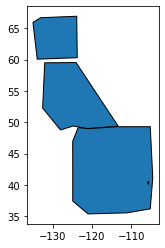

In [47]:
shp_loc.plot(edgecolor='k');

In [48]:
shp_loc

,id,inven_sel,geometry
0,0,616,"POLYGON ((-105.68419 40.55319, -105.61947 40.5..."
1,1,623,"POLYGON ((-121.23794 49.00086, -124.76653 49.4..."
2,2,635,"POLYGON ((-135.01855 65.94399, -133.07648 66.6..."
3,3,614,"POLYGON ((-123.51553 49.16964, -121.23777 49.0..."


In [49]:
# Test the polygons I drew - each subregion should be equivalent as the sel by id
for sub_id in [635, 623, 616]:
    sel = shp.loc[shp['subm_id'] == sub_id].copy()
    rp = sel.representative_point().to_frame('geometry')
    rp['orig_index'] = sel.index
    intersect = gpd.overlay(rp, shp_loc.loc[shp_loc['inven_sel'] == sub_id], how='intersection')
    odf = sel.loc[intersect['orig_index']]
    assert len(sel) == len(odf)
    
# Also even without preselection
rp = shp.representative_point().to_frame('geometry')
rp['orig_index'] = shp.index
for sub_id in [635, 623]:
    sel = shp.loc[shp['subm_id'] == sub_id].copy()
    intersect = gpd.overlay(rp, shp_loc.loc[shp_loc['inven_sel'] == sub_id], how='intersection')
    odf = shp.loc[intersect['orig_index']]
    assert len(sel) == len(odf)   
    
# for 614, 616 we mix and mingle but I trust what we have done below

### Apply selection criteria to create the RGI7 data subset

In [50]:
# for northern Canada we use 'subm_id' 635 by analyst 'Berthier, Etienne'
RGI_ss_NCan = shp.loc[shp['subm_id'] == 635].copy()
len(RGI_ss_NCan), len(RGI_ss_NCan.loc[np.round(RGI_ss_NCan['area'] * 1e-6, 3) < 0.01])

(1235, 0)

In [51]:
# for southern Canada we use 'subm_id' 623 by analyst 'Bolch, Tobias'
RGI_ss_SCan = shp.loc[shp['subm_id'] == 623].copy()
print(len(RGI_ss_SCan), len(RGI_ss_SCan.loc[np.round(RGI_ss_SCan['area'] * 1e-6, 3) < 0.01]))
RGI_ss_SCan = RGI_ss_SCan.loc[np.round(RGI_ss_SCan['area'] * 1e-6, 3) >= 0.01].copy()
len(RGI_ss_SCan)

12464 1


12463

In [52]:
# For CONUS we use 'subm_id' 614 by analyst 'Fountain, Andrew G.' except for colorado
RGI_ss_CONUS = shp.loc[shp['subm_id'] == 614].copy()
print(len(RGI_ss_CONUS))
rp = RGI_ss_CONUS.representative_point().to_frame('geometry')
rp['orig_index'] = RGI_ss_CONUS.index
intersect = gpd.overlay(rp, shp_loc.loc[shp_loc['inven_sel'] == 614], how='intersection')
RGI_ss_CONUS = RGI_ss_CONUS.loc[intersect['orig_index']].copy()
print(len(RGI_ss_CONUS), len(RGI_ss_CONUS.loc[np.round(RGI_ss_CONUS['area'] * 1e-6, 3) < 0.01]))
RGI_ss_CONUS = RGI_ss_CONUS.loc[np.round(RGI_ss_CONUS['area'] * 1e-6, 3) >= 0.01].copy()
len(RGI_ss_CONUS)

5167
5131 7


5124

In [53]:
# For Colorado we use 'subm_id' 616 by analyst 'Fountain, Andrew G.' 
RGI_ss_Colo = shp.loc[shp['subm_id'] == 616].copy()
print(len(RGI_ss_Colo), len(RGI_ss_Colo.loc[np.round(RGI_ss_Colo['area'] * 1e-6, 3) < 0.01]))
RGI_ss_Colo = RGI_ss_Colo.loc[np.round(RGI_ss_Colo['area'] * 1e-6, 3) >= 0.01].copy()
len(RGI_ss_Colo)

42 9


33

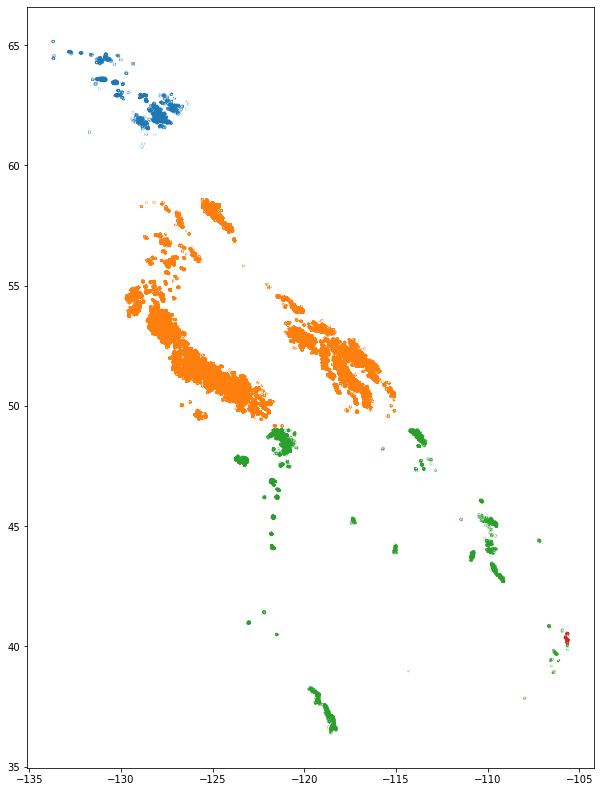

In [54]:
f, ax = plt.subplots(figsize=(14, 14))
RGI_ss_NCan.plot(ax=ax, edgecolor='C0', linewidth=3)
RGI_ss_SCan.plot(ax=ax, edgecolor='C1', linewidth=3)
RGI_ss_CONUS.plot(ax=ax, edgecolor='C2', linewidth=3);
RGI_ss_Colo.plot(ax=ax, edgecolor='C3', linewidth=3);

In [55]:
# combine the geodataframes
RGI_ss = pd.concat([RGI_ss_NCan, RGI_ss_SCan, RGI_ss_CONUS, RGI_ss_Colo])

## Write out and tar 

In [56]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
RGI_ss.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI02.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI02'], returncode=0)


## New RGI-file created - Check result!

### load reference data (here RGI6) to enable comparison

In [57]:
# Just to know the name of the file to open from zip
import zipfile
with zipfile.ZipFile(rgi6_reg_file, "r") as z:
    for f in z.filelist:
        if '.shp' in f.filename:
            fname = f.filename

# load reference data
ref_odf = gpd.read_file('zip://' + rgi6_reg_file + '/' + fname)

## Compare new RGI7-file to RGI6

### Number of elements (differences depict problems)

In [58]:
print('Number of glaciers in new RGI:', len(RGI_ss))
print('Number of glaciers in RGI6:', len(ref_odf))
print('Difference:', len(RGI_ss)-len(ref_odf))

Number of glaciers in new RGI: 18855
Number of glaciers in RGI6: 18855
Difference: 0


### How many nominal glaciers were there in RGI06?

In [59]:
len(ref_odf.loc[ref_odf.Status == 2])

0

### Total area

In [60]:
# add an area field to RGI_ss and reference data
RGI_ss['area'] = RGI_ss.to_crs({'proj':'cea'}).area
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area

In [61]:
# print and compare area values
Area_RGI = RGI_ss['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_RGI)
Area_ref = ref_odf['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_ref)
d = (Area_RGI - Area_ref)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 14389.929311323913
Area RGI6 [km²]: 14524.240019596462
Area difference [km²]: -134.31070827254916


### Northern Canada (635, Berthier, no problem there):  

In [62]:
rp = ref_odf.representative_point().to_frame('geometry')
rp['orig_index'] = ref_odf.index
intersect = gpd.overlay(rp, shp_loc.loc[shp_loc['inven_sel'] == 635], how='intersection')
ref_odf_NCan = ref_odf.loc[intersect['orig_index']].copy()

In [63]:
print('Number of glaciers in RGI7 subset:', len(RGI_ss_NCan))
print('Number of glaciers in reference data (RGI6):', len(ref_odf_NCan))
print('Difference:', len(RGI_ss_NCan)-len(ref_odf_NCan))

Number of glaciers in RGI7 subset: 1235
Number of glaciers in reference data (RGI6): 1235
Difference: 0


In [64]:
# print and compare area values
Area_7 = RGI_ss_NCan['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_7)
Area_6 = ref_odf_NCan['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_6)
d = (Area_7 - Area_6)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 656.5317836977715
Area RGI6 [km²]: 656.5319107844741
Area difference [km²]: -0.0001270867026050837


This is brilliant! No issue there.

### Southern Canada (623, Bolch, problems):  

In [65]:
rp = ref_odf.representative_point().to_frame('geometry')
rp['orig_index'] = ref_odf.index
intersect = gpd.overlay(rp, shp_loc.loc[shp_loc['inven_sel'] == 623], how='intersection')
ref_odf_SCan = ref_odf.loc[intersect['orig_index']].copy()

In [66]:
print('Number of glaciers in RGI7 subset:', len(RGI_ss_SCan))
print('Number of glaciers in reference data (RGI6):', len(ref_odf_SCan))
print('Difference:', len(RGI_ss_SCan)-len(ref_odf_SCan))

Number of glaciers in RGI7 subset: 12463
Number of glaciers in reference data (RGI6): 12464
Difference: -1


In [67]:
# print and compare area values
Area_7 = RGI_ss_SCan['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_7)
Area_6 = ref_odf_SCan['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_6)
d = (Area_7 - Area_6)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 13054.772703665398
Area RGI6 [km²]: 13195.162964834108
Area difference [km²]: -140.3902611687099


But the area clearly is not, which is visible in GIS ([GH issue](https://github.com/GLIMS-RGI/glims_issue_tracker/issues/8)).

There are two glaciers missing from GLIMS based on GIS, and we have one more glacier in GLIMS (this is expected)

In [68]:
a1 = ref_odf_SCan.loc[ref_odf_SCan.RGIId.isin(['RGI60-02.03578', 'RGI60-02.02611'])]['area'].sum() * 1e-6
a2 = RGI_ss_SCan.loc[RGI_ss_SCan.anlys_id == 380747]['area'].sum() * 1e-6 
a1, a2, a1 - a2

(147.04689962219334, 0.42227292934575933, 146.62462669284758)

Arg, we still have 6 km2 more in GLIMS than RGI6. Quick check on GIS reveals that some polygons in polygons are in GLIMS but not RGI, and some rock outcrops are in RGI but not GLIMS (see GH issue).

### CONUS (614, Fountain, problems):  

In [69]:
rp = ref_odf.representative_point().to_frame('geometry')
rp['orig_index'] = ref_odf.index
intersect = gpd.overlay(rp, shp_loc.loc[shp_loc['inven_sel'] == 614], how='intersection')
ref_odf_CONUS = ref_odf.loc[intersect['orig_index']].copy()

In [70]:
print('Number of glaciers in RGI7 subset:', len(RGI_ss_CONUS))
print('Number of glaciers in reference data (RGI6):', len(ref_odf_CONUS))
print('Difference:', len(RGI_ss_CONUS)-len(ref_odf_CONUS))

Number of glaciers in RGI7 subset: 5124
Number of glaciers in reference data (RGI6): 5123
Difference: 1


In [71]:
# print and compare area values
Area_7 = RGI_ss_CONUS['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_7)
Area_6 = ref_odf_CONUS['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_6)
d = (Area_7 - Area_6)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 677.5129289389
Area RGI6 [km²]: 671.433249726907
Area difference [km²]: 6.079679211993039


I don't know about the one glacier difference (not a big deal), but the missing area comes from missing rock outcrops (

But the area clearly is not, which is visible in GIS ([GH issue](https://github.com/GLIMS-RGI/glims_issue_tracker/issues/8)).

There are two glaciers missing from GLIMS based on GIS, and we have one more glacier in GLIMS (this is expected)

### Colorado (616, Fountain, OK):  

In [72]:
rp = ref_odf.representative_point().to_frame('geometry')
rp['orig_index'] = ref_odf.index
intersect = gpd.overlay(rp, shp_loc.loc[shp_loc['inven_sel'] == 616], how='intersection')
ref_odf_Colo = ref_odf.loc[intersect['orig_index']].copy()

In [73]:
print('Number of glaciers in RGI7 subset:', len(RGI_ss_Colo))
print('Number of glaciers in reference data (RGI6):', len(ref_odf_Colo))
print('Difference:', len(RGI_ss_Colo)-len(ref_odf_Colo))

Number of glaciers in RGI7 subset: 33
Number of glaciers in reference data (RGI6): 33
Difference: 0


In [74]:
# print and compare area values
Area_7 = RGI_ss_Colo['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_7)
Area_6 = ref_odf_Colo['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_6)
d = (Area_7 - Area_6)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 1.111895021844131
Area RGI6 [km²]: 1.111894250971996
Area difference [km²]: 7.708721350141445e-07
